## Import modules

In [3]:
from common_dirs_fns import *
import FlowCal
import pandas as pd
import numpy as np
import regex
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
# Specify matplotlib formatting
%matplotlib inline
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.
mpl.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 7})

## Import FACS .fcs files

In [5]:
samples = pd.read_excel(facs_path+'FCS_Files/fcs_file_legend.xlsx','Samples')
samples['File Path']=facs_path+'FCS_Files/'+samples['File Path']
sample_data = {}

for i in samples.index:
    s = FlowCal.io.FCSData(samples.loc[i,'File Path'])
    
    '''
    Transforming to rfi does not change the fluorescence values from the .fcs files because the FACS gain is None
    and FlowCal interprets None as a gain of 1 for FACS machines with linear amplifiers.
    '''
    s = FlowCal.transform.to_rfi(s)
    
    sample_data[samples.loc[i,'ID']] = s

## Import sort data

Bins 1-8 contain the least fluorescent to most fluorescent cells, respectively. <br />
The "FSC-BSC" sort included any events that fell within the FSC-BSC sort gate regardless of fluorescence. <br />
There are two separate sort files corresponding to the two 6-well plates that were used during sorting.

In [6]:
# Import sort data and assign bin information to each event based on dictionary keys

msort1_labels = {'A1':'Bin 2',
                'A2':'Bin 3',
                'A3':'Bin 4',
                'B1':'Bin 5',
                'B2':'Bin 6',
                'B3':'Bin 7'}

msort2_labels = {'A1':'FSC-BSC',
                'A2':'Bin 1',
                'A3':'Bin 8'}

msort1 = pd.read_csv(facs_path+'Sort_Data/hAMP - 1_[Index 6 Well] Data Source - 1_Index.csv')
msort1['Sort'] = 1
msort1['Gate'] = msort1['Index'].apply(lambda x: msort1_labels[x])

msort2 = pd.read_csv(facs_path+'Sort_Data/hAMP - 2_[Index 6 Well] Data Source - 1_Index_FSC-BSC.csv')
msort2['Sort'] = 2
msort2['Gate'] = msort2['Index'].apply(lambda x: msort2_labels[x])

msort = msort1.append(msort2)

## Import and calculate bin statistics

The FACS returns statistics about every gate used to sort, including the percent of events in each fluorescence bin. <br />
There are two separate sort statistics files corresponding to the two 6-well plates that were used during sorting.

In [7]:
# Import and process sort statistics
m_stats1 = pd.read_csv(facs_path+'Sort_Stats/hAMP - 1.csv')
m_stats2 = pd.read_csv(facs_path+'Sort_Stats/hAMP - 2.csv')

def process_stats_table(m_stats):
    # Change bin nomenclature from 'Bin1' -> 'Bin 1'
    m_stats['Name'] = m_stats['Name'].mask(m_stats['Name'].str.contains('Bin'),
                                          m_stats['Name'].apply(lambda x: ' '.join(regex.split('(\d.*)',x))))
    m_stats['Name'] = m_stats['Name'].str.strip()
    m_stats.set_index('Name',inplace=True)
    return m_stats

for m_stats in [m_stats1, m_stats2]:
    process_stats_table(m_stats)

# Reformat information about which bins were collected in which sort
stats_dict = {'mixed1':list(msort1_labels.values()),
             'mixed2':list(msort2_labels.values())}

# Append statistics for sort 1 and sort 2
mixed_stats = pd.concat([m_stats1.loc[stats_dict['mixed1']],m_stats2.loc[stats_dict['mixed2']]]).sort_index(level=0,sort_remaining=False)

In [8]:
# Calculate bin boundaries and bin widths based on sorted events
bin_bounds_df = pd.DataFrame(columns=['Minimum','Maximum'])

for bin_name in m_stats.index:
    min_val = msort[msort['Gate']==bin_name]['EGFP-A-Compensated'].min()
    max_val = msort[msort['Gate']==bin_name]['EGFP-A-Compensated'].max()
    bin_bounds_df = bin_bounds_df.append(pd.DataFrame.from_dict(
                                {bin_name:[min_val, max_val]}, orient='index',columns=['Minimum','Maximum']))

mixed_stats = mixed_stats.join(bin_bounds_df)
mixed_stats['BinWidth'] = mixed_stats['Maximum']-mixed_stats['Minimum']

In addition to recording data for sorted events, in each sort, we recorded 100,000 non-fluorescence-gated events. These non-gated events enable us to calculate the percentage of events contained in each fluorescence bin during the sorts.

In [9]:
# Import event data for each sort
hAMP1_data = pd.read_csv(facs_path+'Sort_Population_Data/user1_Experiment 12_6_2019 11204 PM_Sample Group - 1_hAMP - 1_[Index 6 Well] Data Source - 1.csv')
hAMP2_data = pd.read_csv(facs_path+'Sort_Population_Data/user1_Experiment 12_6_2019 11204 PM_Sample Group - 1_hAMP - 2_[Index 6 Well] Data Source - 1.csv')

# Combine the events from each sort
hAMP_data = hAMP1_data.append(hAMP2_data)

# Calculate the number of events that occurred in each bin
num_events_dict = {}
hAMP_data_fl = hAMP_data['EGFP-A-Compensated']
for bin_num in np.arange(1,9):
    bin_name = 'Bin '+str(bin_num)
    num_events_dict[bin_name] = len(hAMP_data_fl[(hAMP_data_fl < mixed_stats.loc[bin_name,'Maximum'])&
                                                 (hAMP_data_fl > mixed_stats.loc[bin_name,'Minimum'])])

# Incorporate the percentage of events in each bin into mixed_stats
num_events = pd.Series(num_events_dict)
mixed_stats['FracTotalCalculated'] = num_events/len(hAMP_data_fl)

# Save statistics information as a csv file
mixed_stats.to_csv(analysis_path+'mixed_stats.csv')

## Plots

Superimpose each of the 8 fluorescence bins on the fluorescence distribution of the peptide library.

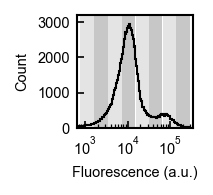

In [10]:
fig = plt.figure(figsize=(1., 1.), dpi=150)
ax = plt.subplot()

mixed_stats_bins = mixed_stats.drop('FSC-BSC',axis=0)
upper = mixed_stats_bins['Maximum'].values
lower = mixed_stats_bins['Minimum'].values

ax_lims = [lower[0]/1.2, upper[-1]*1.2]
bins = np.logspace(np.log10(ax_lims[0]), np.log10(ax_lims[1]), 300)

plt.hist(hAMP_data['EGFP-A-Compensated'], bins=bins, color='k',
         linewidth=1,histtype='step',density=False,linestyle='-')
plt.ylabel('Count')
plt.xlabel('Fluorescence (a.u.)')

colors = ['#bdbdbd','#737373']*4
for i in range(1,9):
    plt.axvspan(mixed_stats.loc['Bin '+str(i),'Minimum'], mixed_stats.loc['Bin '+str(i),'Maximum'],
               alpha=0.4, color=colors[i-1], linewidth=0,zorder=-1)
    
plt.xscale('log')
plt.xlim(ax_lims)
plt.ylim([0, 3200])
plt.xticks([10**3,10**4,10**5])
plt.yticks([0, 1000, 2000, 3000])

ax.tick_params(axis='both',direction="in", which='both')

locmaj = mpl.ticker.LogLocator(base=10., numticks=7)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
                                          numticks=7)
ax.xaxis.set_major_locator(locmaj)
ax.xaxis.set_minor_locator(locmin)

plt.savefig(figures_path+'hist_bins_counts.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path+'hist_bins_counts.svg', dpi=300, bbox_inches='tight')

Compare control fluorescence distributions to the peptide (hAMP) library distribution.

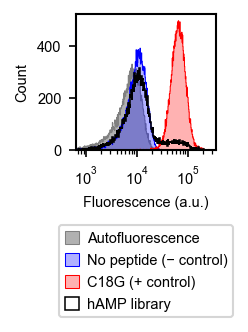

In [11]:
fig = plt.figure(figsize=(1.2,1.2),dpi=150)
ax = plt.subplot()

spacing = 1.2
xlim = [mixed_stats.loc['Bin 1','Minimum']/spacing, mixed_stats.loc['Bin 8','Maximum']*spacing]
bins = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]),500)

for plasmid, color, zorder, edgecolor in zip(['None','pKB225','pKB223'],
                                             ['k','b','r'],
                                             [-1,0,0],
                                             ['grey','b','r']):
    
    # 5th column corresponds to Channel 5 on the FACS, FL2-A (mNeonGreen channel)
    plt.hist(sample_data[samples[samples['Plasmid(s)']==plasmid]['ID'].values[0]][:,5],
        bins=bins, facecolor=mpl.colors.to_rgba(color,alpha=0.3),edgecolor=edgecolor,
        linewidth=0.5,histtype='stepfilled',density=False,linestyle='-',zorder=zorder)

plt.ylabel('Count')
plt.xlabel('Fluorescence (a.u.)')
plt.xscale('log')
plt.xlim(xlim)
plt.xticks([10**3,10**4,10**5])

locmaj = mpl.ticker.LogLocator(base=10., numticks=4)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
                                          numticks=4)
ax.xaxis.set_major_locator(locmaj)
ax.xaxis.set_minor_locator(locmin)

# hAMP data plotted here is from 30,000 events collected on the same day in a separate file from
# the events during sorting
plt.hist(sample_data[samples[samples['Plasmid(s)']=='hAMP']['ID'].values[0]][:,5],
        bins=bins, color='k',linewidth=0.75,histtype='step',density=False,linestyle='-')

plt.legend(['Autofluorescence','No peptide (− control)','C18G (+ control)','hAMP library'],
           loc='upper center', bbox_to_anchor=[0.5,-0.5],
           handlelength=1, handleheight=1, fontsize=7, handletextpad=0.5)

plt.savefig(figures_path+'hist_controls.png', dpi=300, bbox_inches='tight')
plt.savefig(figures_path+'hist_controls.svg', dpi=300, bbox_inches='tight')

## Calculate minimum expected fold change in fluorescence

In [12]:
# Calculate fluorescence means of mNeonGreen-negative cell population (autofluorescence)
# and of control with no displayed peptide
autofluorescence = sample_data[samples[samples['Plasmid(s)']=='None']['ID'].values[0]][:,5]
no_peptide = sample_data[samples[samples['Plasmid(s)']=='pKB225']['ID'].values[0]][:,5]

# The value below represents the lowest expected fold change value that will be calculated using the NGS data
# Any calculated fold changes that fall below this value are likely to be plasmids with mutations in mNeonGreen
autofluorescence.mean()/no_peptide.mean()

0.7163834402336696

In [13]:
autofl_df = pd.DataFrame.from_dict({'Mean':autofluorescence.mean(),
                                   'Fold Change':autofluorescence.mean()/no_peptide.mean()},
                                  orient='index', columns=['Value'])

In [14]:
autofl_df.to_csv(analysis_path+'autofluorescence.csv')